In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools

from typing import NamedTuple

In [2]:
castle_values = list(range(1, 13))

distribution = np.array([1.0] * 12)
distribution = distribution / np.sum(distribution)

In [3]:
def draw_allocations(distribution, rng, num_allocations=10, allocation_sum=1000):
    assert np.abs(np.sum(distribution) - 1.0) < 1e-6
    num_castles = len(distribution)
    samples = rng.multinomial(1000, distribution, num_allocations)
    return samples

In [27]:
rng = np.random.default_rng(12345)
players = [distribution / np.sum(distribution)] * 2
NUM_ALLOCATIONS = 100
result_0 = draw_allocations(players[0], rng, num_allocations=NUM_ALLOCATIONS)
result_1 = draw_allocations(players[1], rng, num_allocations=NUM_ALLOCATIONS)




In [111]:
class FightResult(NamedTuple):
    # note that first index is player_1's selection
    player_1_wins: list[tuple[int, int]]
    # note that first index is player_2's selection
    player_2_wins: list[tuple[int, int]]
    num_fights: int

def fight(alloc_1, alloc_2, battlefield_values) -> FightResult:
    assert alloc_1.shape[1] == alloc_2.shape[1]
    player_1_wins = []
    player_2_wins = []
    num_fights = 0
    for i in range(alloc_1.shape[0]):
        num_fights += alloc_2.shape[0]
        # alloc_2.shape[0] x num_castles
        delta = alloc_1[i] - alloc_2
        player_1_mask = delta > 0
        player_2_mask = delta < 0
        # sum over 
        player_1_score = np.sum(player_1_mask * battlefield_values, axis=1)
        player_2_score = np.sum(player_2_mask * battlefield_values, axis=1)
        
        curr_player_1_wins = np.nonzero(player_1_score > player_2_score)
        curr_player_2_wins = np.nonzero(player_2_score > player_1_score)
        
        for j in curr_player_1_wins[0]:
            player_1_wins.append((i, j))
        for j in curr_player_2_wins[0]:
            player_2_wins.append((j, i))
        
#         if player_1_score > player_2_score:
#             player_1_wins.append((i, j))
#         elif player_2_score > player_1_score:
#             player_2_wins.append((j, i))
    return FightResult(player_1_wins = player_1_wins, player_2_wins = player_2_wins, num_fights = num_fights)
        
    

In [50]:
fight_result = fight(result_0, result_1, battlefield_values=castle_values)

In [52]:
indices, counts = np.unique([i for i, j in fight_result.player_1_wins], return_counts=True)

In [55]:
indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [56]:
counts

array([56, 25, 25, 70, 71, 64, 73, 41, 37, 66, 42, 69, 31, 63, 38, 38, 60,
       52, 66, 61, 61, 62, 36, 66, 70, 41, 72, 49, 48, 62, 61, 31, 59, 45,
       51, 65, 57, 41, 60, 55, 38, 54, 26, 40, 58, 53, 60, 32, 69, 45, 65,
       14, 32, 63, 23, 35, 13, 41, 57, 54, 46, 30, 43, 61, 77, 52, 63, 66,
       39, 70, 55, 52, 42, 58, 34, 65, 10, 57, 33, 26, 39, 45, 59, 29, 48,
       53, 42, 55, 32, 64, 52, 61, 66, 38, 20, 40, 23, 35, 78, 36])

In [57]:
result_0.shape

(100, 12)

In [58]:
winners = result_0[indices]

<IPython.core.display.Javascript object>


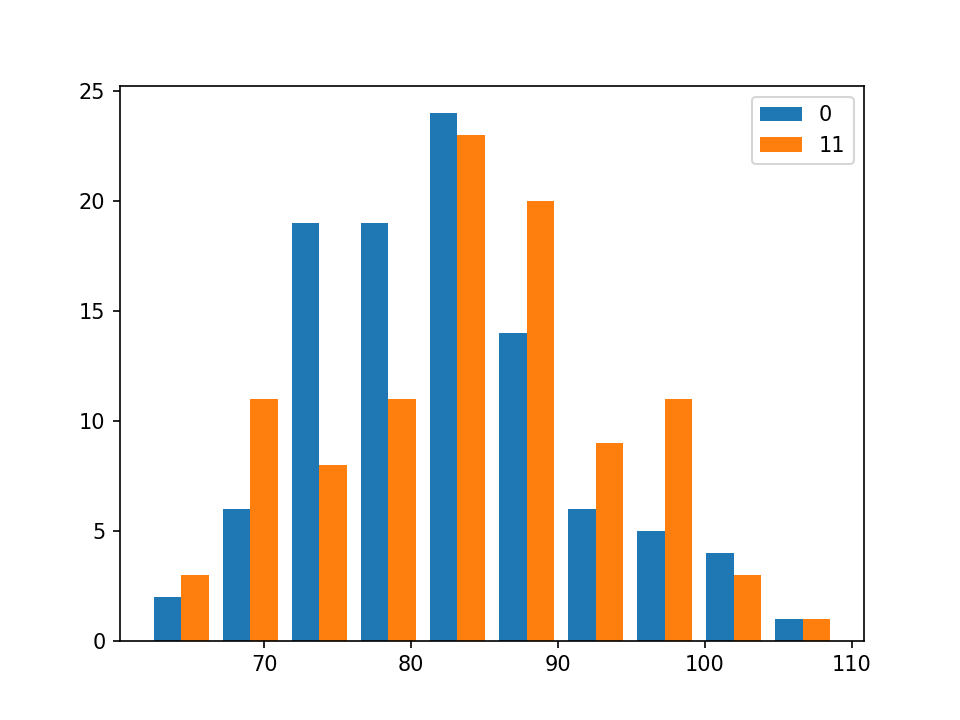

In [59]:
plt.figure()
plt.hist(winners[:,[0, 11]], label=[0, 11])
plt.legend()


In [60]:
new_dist = np.average(result_0[indices], axis=0, weights = counts)
new_dist = new_dist/np.sum(new_dist)

In [61]:
def update_distribution(initial_dist, opponent_dist, num_allocations, castle_values, rng):
    player_alloc = draw_allocations(initial_dist, rng, num_allocations)
    oppo_alloc = draw_allocations(opponent_dist, rng, num_allocations)
    
    fight_result = fight(player_alloc, oppo_alloc, battlefield_values=castle_values)
    
    player_1_winners, player_1_counts = np.unique([i for i, j in fight_result.player_1_wins], return_counts=True)
    
    new_dist = np.average(player_alloc[player_1_winners], axis=0, weights = player_1_counts)
    new_dist = new_dist/np.sum(new_dist)
    return new_dist, float(len(fight_result.player_1_wins)) / fight_result.num_fights


In [62]:
new_dist = update_distribution(distribution, distribution, 100, castle_values, rng)

In [79]:

def find_equilibrium(initial_distribution, num_iterations=10000):
    player_dists = [initial_distribution]
    win_percentage = []
    for i in range(num_iterations):

        if i < 100:
            oppo_idx = 0
        else:
            oppo_delta = int(100 * np.exp(-(i - 100)/2000))
            oppo_idx = i - oppo_delta
        if i % 1000 == 0:
            print(i, len(player_dists) - oppo_idx)

        new_dist, win_pct = update_distribution(player_dists[-1], player_dists[oppo_idx], 100, castle_values, rng)
        player_dists.append(new_dist)
        win_percentage.append(win_pct)
    return player_dists, win_percentage



In [93]:
distribution = np.array([1.0] * 12)
distribution = distribution / np.sum(distribution)
new_dists, win_percentage = find_equilibrium(distribution, 50000)

0 1
1000 64
2000 39
3000 24
4000 15
5000 9
6000 6
7000 4
8000 2
9000 2
10000 1
11000 1
12000 1
13000 1
14000 1
15000 1
16000 1
17000 1
18000 1
19000 1
20000 1
21000 1
22000 1
23000 1
24000 1
25000 1
26000 1
27000 1
28000 1
29000 1
30000 1
31000 1
32000 1
33000 1
34000 1
35000 1
36000 1
37000 1
38000 1
39000 1
40000 1
41000 1
42000 1
43000 1
44000 1
45000 1
46000 1
47000 1
48000 1
49000 1


In [94]:
def plot_dists(dists, win_pct):
    plt.figure()
    for i, dist in enumerate(dists[::2000]):
        plt.plot(dist, label=i)
    plt.legend()

    plt.figure()
    plt.plot(win_pct)
    plt.title('Win Fraction over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Win Fraction')

<IPython.core.display.Javascript object>


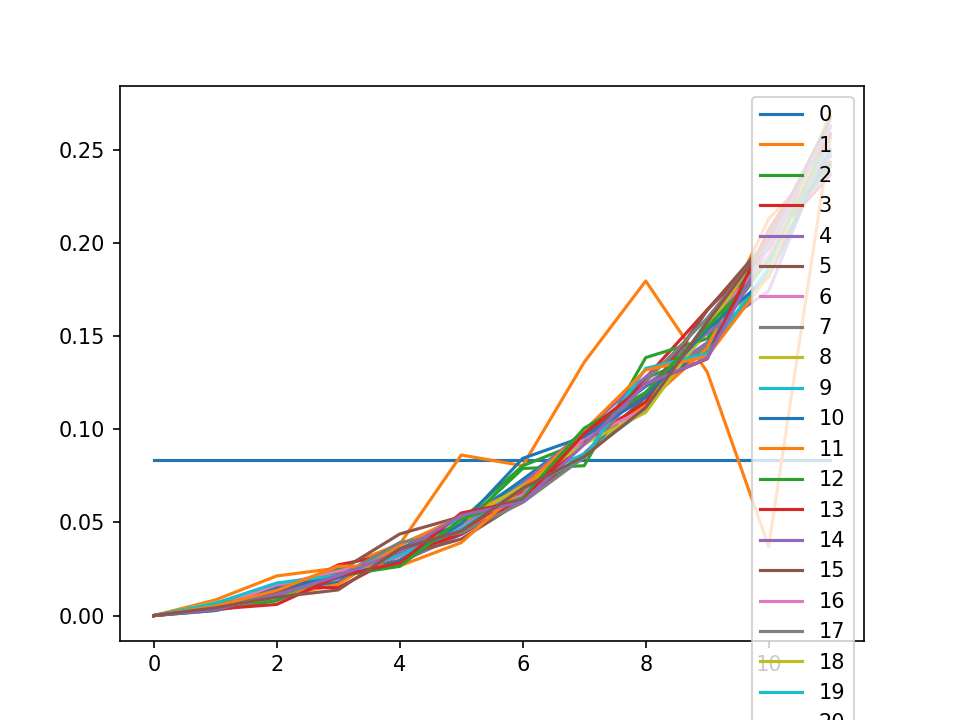

<IPython.core.display.Javascript object>


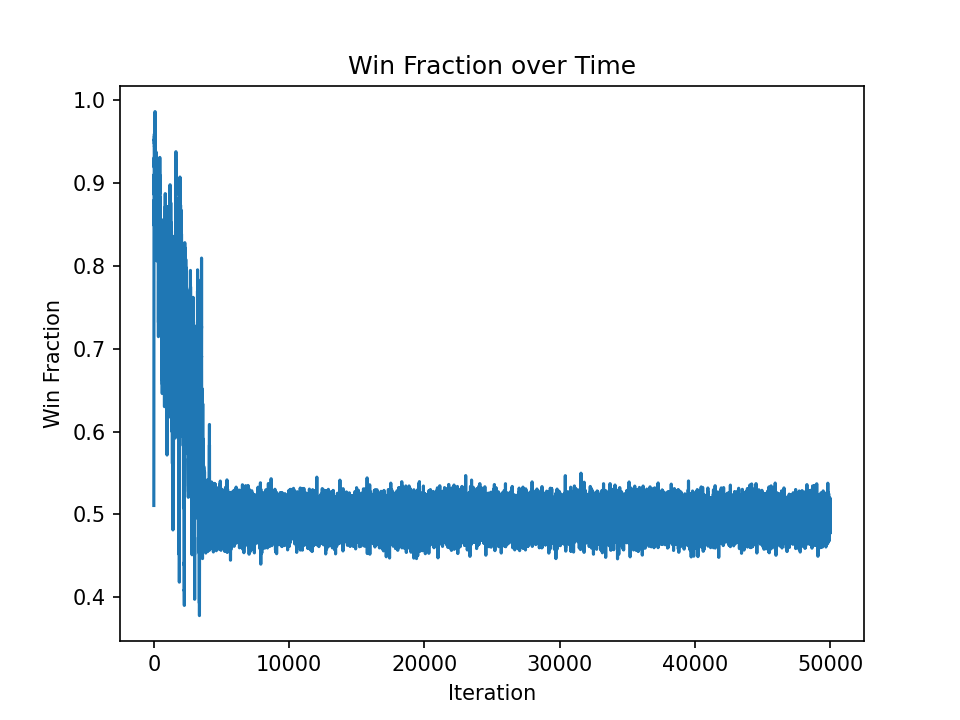

In [95]:
plot_dists(new_dists, win_percentage)

In [86]:
low_val_dist = np.array([0.01, 0.01, 1, 1, 1, 1, 1, 1, 1, 0.01, 0.01, 0.01])
low_val_dist = low_val_dist / np.sum(low_val_dist)

low_val_dists, low_val_win_percentage = find_equilibrium(low_val_dist)

0 1
1000 64
2000 39
3000 24
4000 15
5000 9
6000 6
7000 4
8000 2
9000 2


<IPython.core.display.Javascript object>


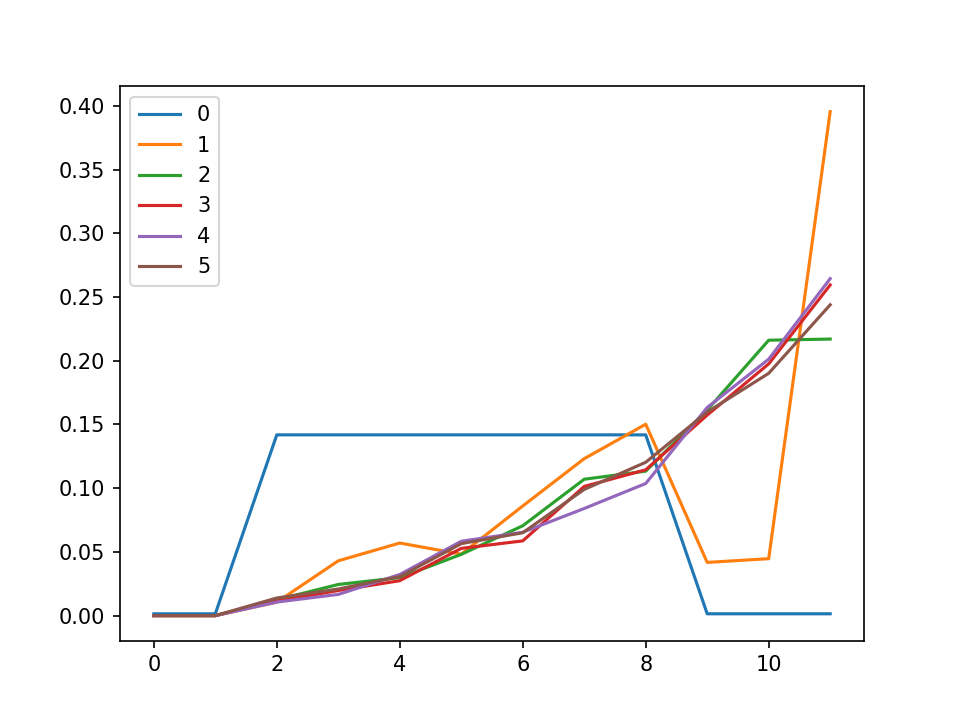

<IPython.core.display.Javascript object>


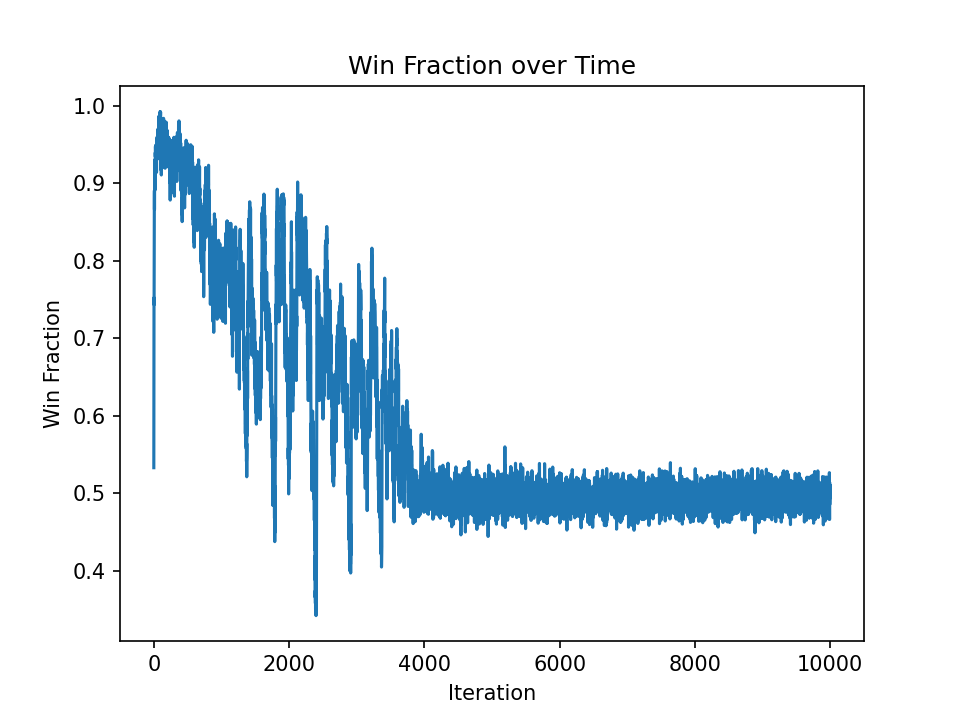

In [87]:
plot_dists(low_val_dists, low_val_win_percentage)

In [99]:
weird_dist = np.array([1.0, 1.0, 0.25, 0.25,0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 1.0, 1.0])
weird_dist = weird_dist / np.sum(weird_dist)

weird_dists, weird_win_percentage = find_equilibrium(weird_dist)

0 1
1000 64
2000 39
3000 24
4000 15
5000 9
6000 6
7000 4
8000 2
9000 2


<IPython.core.display.Javascript object>


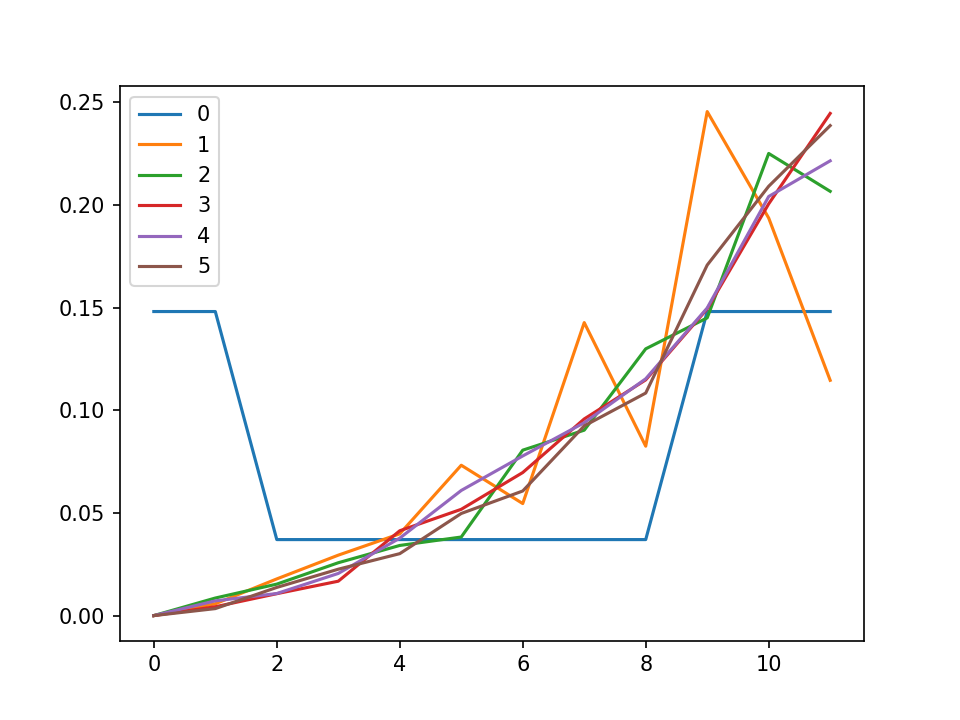

<IPython.core.display.Javascript object>


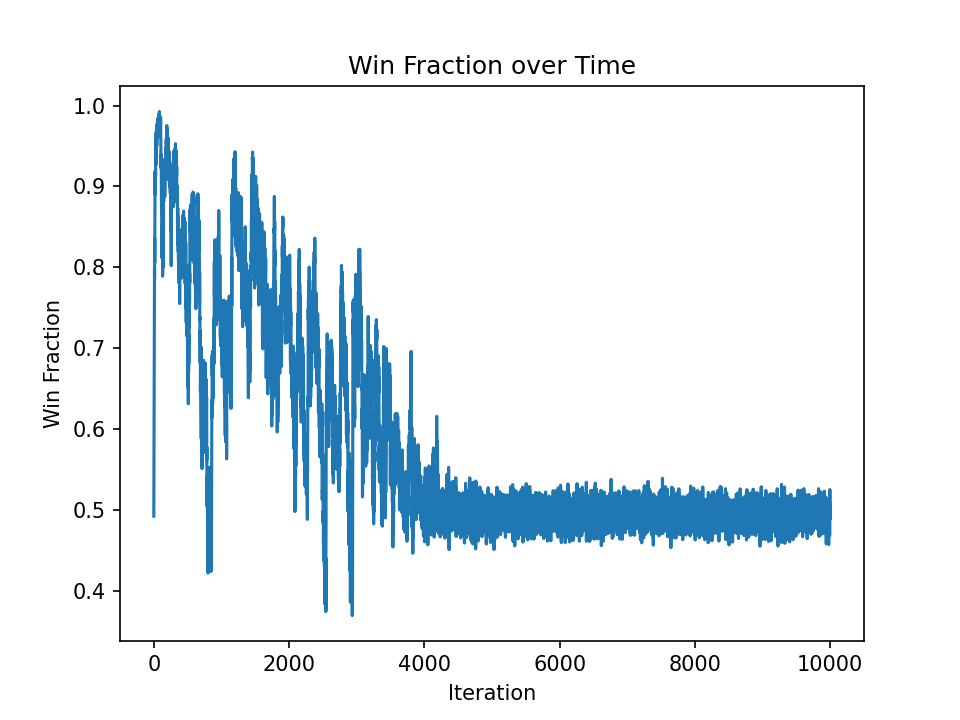

In [100]:
plot_dists(weird_dists, weird_win_percentage)

<IPython.core.display.Javascript object>


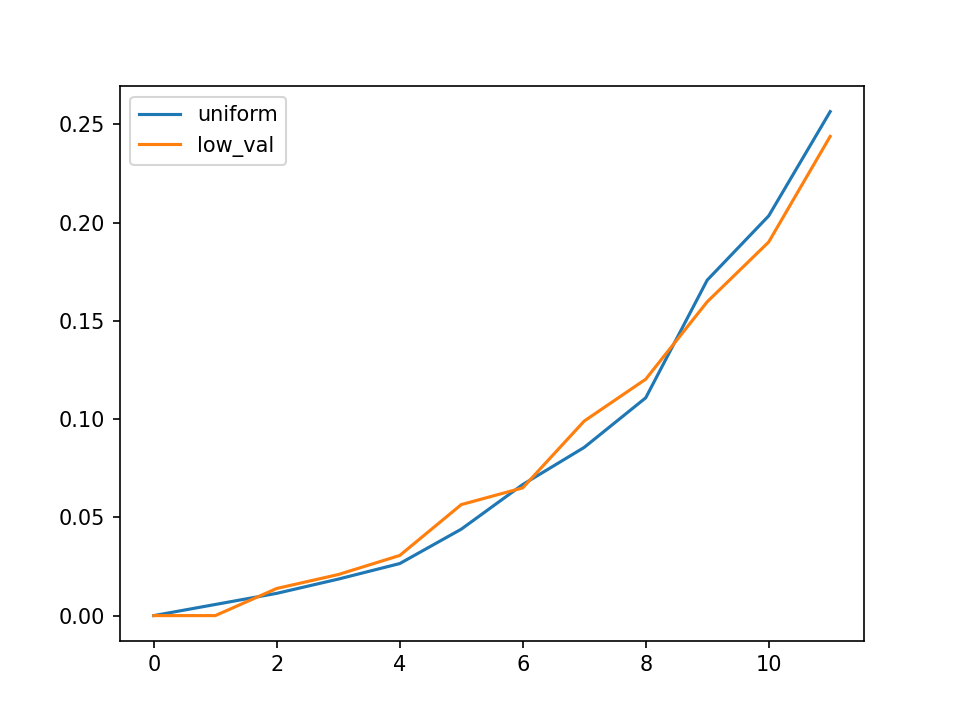

In [88]:
p

In [126]:
adversarial_dist = new_dists[-2].copy()
adversarial_dist[0:6] = 0.001
adversarial_dist = adversarial_dist / np.sum(adversarial_dist)

In [127]:
f_1 = draw_allocations(new_dists[-2], rng, 100)
f_2 = draw_allocations(adversarial_dist, rng, 100)

result = fight(f_1, f_2, castle_values)

In [128]:
new_adversarial, new_adversarial_pct = find_equilibrium(adversarial_dist)

0 1
1000 64
2000 39
3000 24
4000 15
5000 9
6000 6
7000 4
8000 2
9000 2


<IPython.core.display.Javascript object>


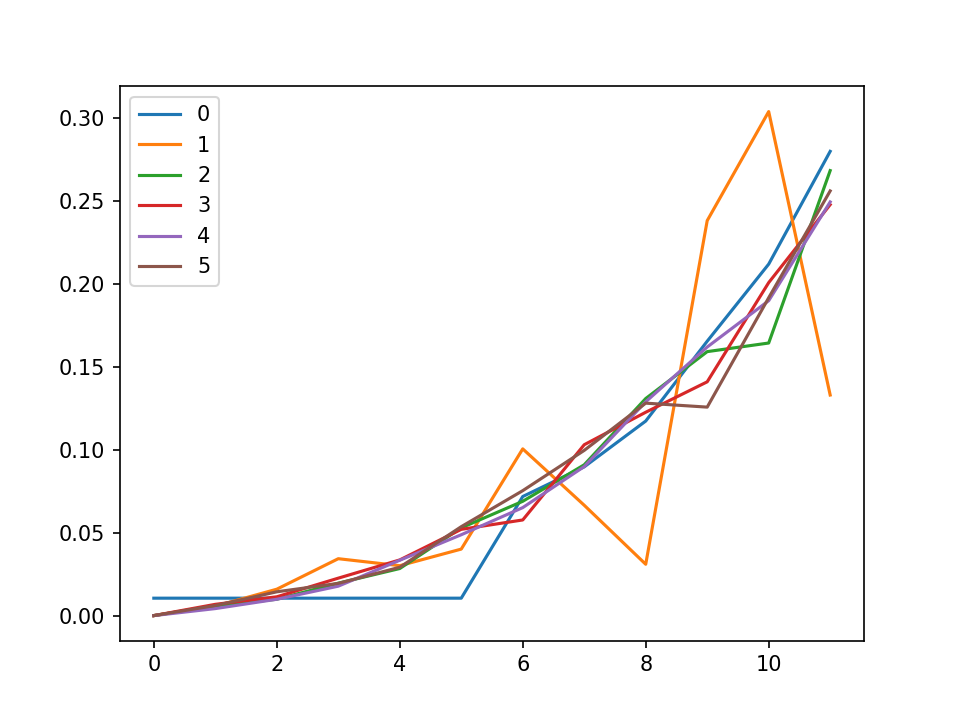

<IPython.core.display.Javascript object>


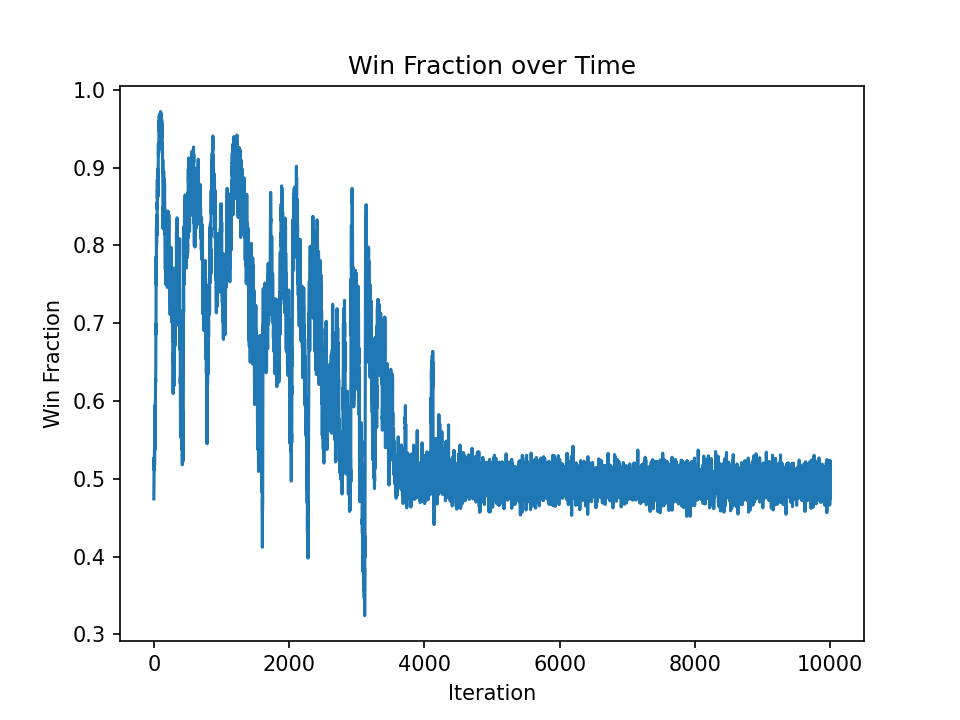

In [122]:
plot_dists(new_adversarial, new_adversarial_pct)